In [1]:
# Import our dependencies
import os 
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf

### Preprocessing Data 

In [2]:
#Import the dataset 
companies_df = pd.read_csv('Unicorn_companies.csv')
new_companies_df = companies_df.drop(['Portfolio Exits'],axis = 1)
new_companies_df.head()

,Company,Valuation ($B),Date Joined,Country,City,Industry,Select Inverstors,Founded Year,Total Raised,Financial Stage,Investors Count,Deal Terms
0,Bytedance,$140,4/7/2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S...",2012,$7.44B,IPO,28,8
1,SpaceX,$100.3,12/1/2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",2002,$6.874B,None,29,12
2,Stripe,$95,1/23/2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",2010,$2.901B,Asset,39,12
3,Klarna,$45.6,12/12/2011,Sweden,Stockholm,Fintech,"Institutional Venture Partners, Sequoia Capita...",2005,$3.472B,Acquired,56,13
4,Epic Games,$42,10/26/2018,United States,Cary,Other,"Tencent Holdings, KKR, Smash Ventures",1991,$4.377B,Acquired,25,5


In [3]:
# Convert Valuation column to float
new_companies_df['Valuation ($B)']= new_companies_df['Valuation ($B)'].str.replace('$','')
new_companies_df['Valuation ($B)'] = new_companies_df['Valuation ($B)'].astype(float)
new_companies_df['Financial Stage'].value_counts()


/Users/Biggaharry/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


None           988
Acquired        22
Divestiture      8
IPO              7
Acq              7
Asset            1
Take             1
Management       1
Reverse          1
Corporate        1
Name: Financial Stage, dtype: int64

In [4]:


#Convert Total Raised column to float
#Credit to https://stackoverflow.com/questions/71543484/kernel-dies-when-processing-dataframe

new_companies_df['Total Raised']= new_companies_df['Total Raised'].str.replace('$','')

def replace(x):
  val_dict = {"M": 1000000, "B": 1000000000,'K':1000,'None': 0}

  for key in val_dict:
    if key in x:
      value = float(x.replace(key, "0")) #float successful after replacing 'B'with '0'
      multiplier = float(val_dict[key])
      return value * multiplier

new_companies_df['Total Raised($)']  = new_companies_df['Total Raised'].apply(replace)
new_companies_df.head()

/Users/Biggaharry/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


,Company,Valuation ($B),Date Joined,Country,City,Industry,Select Inverstors,Founded Year,Total Raised,Financial Stage,Investors Count,Deal Terms,Total Raised($)
0,Bytedance,140.0,4/7/2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S...",2012,7.44B,IPO,28,8,7.440000e+09
1,SpaceX,100.3,12/1/2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",2002,6.874B,None,29,12,6.874000e+09
2,Stripe,95.0,1/23/2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",2010,2.901B,Asset,39,12,2.901000e+09
3,Klarna,45.6,12/12/2011,Sweden,Stockholm,Fintech,"Institutional Venture Partners, Sequoia Capita...",2005,3.472B,Acquired,56,13,3.472000e+09
4,Epic Games,42.0,10/26/2018,United States,Cary,Other,"Tencent Holdings, KKR, Smash Ventures",1991,4.377B,Acquired,25,5,4.377000e+09


In [5]:
#Drop old Total Raised col
new_companies_df = new_companies_df.drop(['Total Raised'],axis=1)
val_counts = new_companies_df['Total Raised($)']
val_counts.dtype

dtype('float64')

In [6]:
#Bin Total Raised($)
invested_bins = [0,1000,1000000,1000000000,1000000000000]
val_counts.groupby(pd.cut(val_counts,invested_bins)).count()

invested_groups = ['<1000','1001-1000000','1000001-1000000000','1000000001-1000000000000']
new_companies_df['Total Raised Ranges($)'] = pd.cut(val_counts,invested_bins, labels=invested_groups)
new_companies_df['Total Raised Ranges($)'].value_counts()

1000001-1000000000          650
1000000001-1000000000000    362
1001-1000000                  1
<1000                         0
Name: Total Raised Ranges($), dtype: int64

In [7]:
#Change Date joined to Year and rename column
# new_companies_df['Date Joined'] = pd.to_datetime(new_companies_df['Date Joined']).dt.to_period('y')
new_companies_df['Date Joined'] = pd.to_datetime(new_companies_df['Date Joined'],infer_datetime_format=True).dt.strftime("%Y")
new_companies_df.rename(columns={'Date Joined':'Year Joined'},inplace=True)
new_companies_df.head()

,Company,Valuation ($B),Year Joined,Country,City,Industry,Select Inverstors,Founded Year,Financial Stage,Investors Count,Deal Terms,Total Raised($),Total Raised Ranges($)
0,Bytedance,140.0,2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S...",2012,IPO,28,8,7.440000e+09,1000000001-1000000000000
1,SpaceX,100.3,2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",2002,None,29,12,6.874000e+09,1000000001-1000000000000
2,Stripe,95.0,2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",2010,Asset,39,12,2.901000e+09,1000000001-1000000000000
3,Klarna,45.6,2011,Sweden,Stockholm,Fintech,"Institutional Venture Partners, Sequoia Capita...",2005,Acquired,56,13,3.472000e+09,1000000001-1000000000000
4,Epic Games,42.0,2018,United States,Cary,Other,"Tencent Holdings, KKR, Smash Ventures",1991,Acquired,25,5,4.377000e+09,1000000001-1000000000000


In [8]:
new_companies_df = new_companies_df[new_companies_df['Founded Year'] !='None']
new_companies_df['Founded Year'].value_counts()
new_companies_df['Transition Time']= new_companies_df['Year Joined'].astype(int) - new_companies_df['Founded Year'].astype(int)
new_companies_df.head()
new_companies_df.to_csv('Unsupervised_dataset.csv', index = False)

### ML model testing 

In [9]:
country_counts=new_companies_df['Country'].value_counts()
country_counts

United States           517
China                   155
India                    61
United Kingdom           40
Germany                  24
France                   23
Israel                   20
Canada                   18
Brazil                   15
South Korea              11
Singapore                11
Indonesia                 7
Japan                     6
Netherlands               6
Mexico                    6
Hong Kong                 6
Australia                 6
Sweden                    6
Ireland                   5
Norway                    4
Switzerland               4
Turkey                    3
Spain                     3
Finland                   3
Belgium                   3
United Arab Emirates      3
Chile                     2
South Africa              2
Thailand                  2
Philippines               2
Denmark                   2
Vietnam                   2
Austria                   2
Colombia                  2
Estonia                   2
Argentina           

<AxesSubplot:ylabel='Density'>

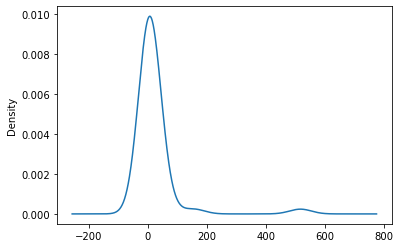

In [10]:
country_counts.plot.density()

In [11]:
#Replace countries with 'Other'
replace_stage = list(country_counts[country_counts <= 100].index)

#Replace in df
for values in replace_stage:
    new_companies_df['Country']=new_companies_df['Country'].replace(values, "Other")
    
#Verify binning was successful 
new_companies_df["Country"].value_counts()

United States    517
Other            322
China            155
Name: Country, dtype: int64

In [12]:
#Select columns to evaluate

X = new_companies_df[['Industry','Total Raised($)', 'Transition Time', 'Country']].copy()
X['Industry'] = LabelEncoder().fit_transform(X['Industry'])
X['Country'] = LabelEncoder().fit_transform(X['Country'])
X = X.dropna()
X.head()

,Industry,Total Raised($),Transition Time,Country
0,3,7.440000e+09,5,0
1,21,6.874000e+09,10,2
2,11,2.901000e+09,4,2
3,11,3.472000e+09,6,1
4,21,4.377000e+09,27,2


In [13]:
# Scale the dataset using MinMaxScaler()
X_scaled = MinMaxScaler().fit_transform(X)
X_scaled

array([[0.09677419, 0.75151515, 0.08823529, 0.        ],
       [0.67741935, 0.69434343, 0.1372549 , 1.        ],
       [0.35483871, 0.2930303 , 0.07843137, 1.        ],
       ...,
       [0.4516129 , 0.04542626, 0.14705882, 1.        ],
       [0.22580645, 0.05308081, 0.08823529, 1.        ],
       [0.51612903, 0.06106061, 0.17647059, 1.        ]])

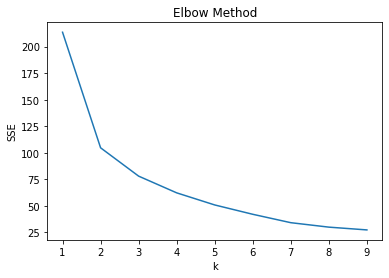

In [14]:
sse = {}
K = range(1, 10)
for k in K:
    kmeanmodel = KMeans(n_clusters=k).fit(X_scaled)
    sse[k]= kmeanmodel.inertia_
    
# Plot
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [15]:
# Create a KMeans model with 3 clusters
model = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

In [16]:
# Calculate predicted values.
y_pred = model.predict(X_scaled)

In [17]:
# Add prediected values onto the original dataframe
df_y = pd.DataFrame(y_pred, columns=['Cluster'])
combined_df = new_companies_df.join(df_y, how='inner')
combined_df.head()

,Company,Valuation ($B),Year Joined,Country,City,Industry,Select Inverstors,Founded Year,Financial Stage,Investors Count,Deal Terms,Total Raised($),Total Raised Ranges($),Transition Time,Cluster
0,Bytedance,140.0,2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S...",2012,IPO,28,8,7.440000e+09,1000000001-1000000000000,5,0
1,SpaceX,100.3,2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",2002,None,29,12,6.874000e+09,1000000001-1000000000000,10,1
2,Stripe,95.0,2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",2010,Asset,39,12,2.901000e+09,1000000001-1000000000000,4,1
3,Klarna,45.6,2011,Other,Stockholm,Fintech,"Institutional Venture Partners, Sequoia Capita...",2005,Acquired,56,13,3.472000e+09,1000000001-1000000000000,6,2
4,Epic Games,42.0,2018,United States,Cary,Other,"Tencent Holdings, KKR, Smash Ventures",1991,Acquired,25,5,4.377000e+09,1000000001-1000000000000,27,1


<AxesSubplot:title={'center':'Transition Time'}, xlabel='[Cluster]'>

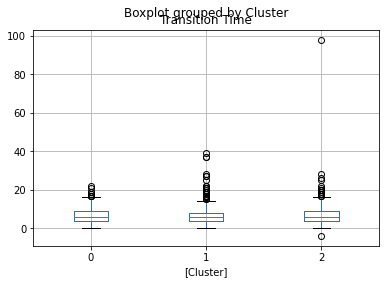

In [18]:
# Plot boxplots of the official time distributions by cluster
combined_df.boxplot(['Transition Time'], by=['Cluster'])

In [19]:
# Plot mean Transition times by Country for each cluster
# cluster_1 = combined_df[combined_df['Cluster'] == 0].groupby(['Country']).mean()['Transition Time']
# cluster_2 = combined_df[combined_df['Cluster'] == 1].groupby(['Country']).mean()['Transition Time']
# cluster_3 = combined_df[combined_df['Cluster'] == 2].groupby(['Country']).mean()['Transition Time']
# clusters = [cluster_1,cluster_2,cluster_3]
# x_axis=np.arange(len(clusters))
# # plt.bar(x_axis, clusters, color='r', alpha=0.5, align="center")
# combined_df.plot.bar(combined_df['Transition Time'].median(),by=['Cluster'])

In [20]:
# #Create the OneHotEncoder instance
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(sparse = False)

# #Create a new df and fit the encoder to the data 
# encode_df = pd.DataFrame(enc.fit_transform(new_companies_df["Country"].values.reshape(-1, 1)))

# #Rename the encoded cols
# encode_df.columns= enc.get_feature_names("Country")
# encode_df.head()

In [21]:
#Generate our categorical variable list 
# companies_cat = new_companies_df.dtypes.index.tolist()

In [22]:
#Check for unique values
# new_companies_df[companies_cat].nunique()

In [23]:
# #Create a OneHotEncoder instance
# enc = OneHotEncoder(sparse = False)

# #Fit and transform the OneHotEncoder using the categorical variable list 
# encode_df = pd.DataFrame(enc.fit_transform(new_companies_df[companies_cat]))

# #Add the encoded variable names to the df
# encode_df.columns = enc.get_feature_names_out(companies_cat)
# encode_df.head()

In [24]:
# #Merge the dataframes and drop the country column from the axis(1)
# new_companies_df.merge(encode_df,left_index=True,right_index=True).drop("Country", 1)

In [25]:
# #Create the StandardScaler instance
# scaler=StandardScaler()

# #Fit the scaler
# scaler.fit(new_companies_df)

# #Scale the data 
# scaled_data=scaler.transform(new_companies_df)

# #Create a dataframe with the scaled data 
# scaled_data = pd.DataFrame(scaled_data, columns=new_companies_df.columns)
# scaled_data.head()